In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline

In [17]:
analyzer = SentimentIntensityAnalyzer()

***VADER (Valence Aware Dictionary for sEntiment Reasoning)***

Best suited for: Social media posts, YouTube comments, and other informal or short-form text.

**Pros:**
1. Extremely fast and lightweight
2. Built into the NLTK library
3. Handles slang, emojis, punctuation, and capitalization effectively

**Cons:** 
- Lexicon-based approach limits its ability to understand sarcasm, irony, or complex contextual nuance
- Classifies comments in foreign languages as neutral

**How it works:**
VADER assigns each comment a compound sentiment score ranging from -1 (most negative) to +1 (most positive). 

**Interpretation:**
- Positive sentiment: score > 0.05
- Negative sentiment: score < -0.05
- Neutral sentiment: between -0.05 and 0.05

Higher absolute values indicate stronger sentiment intensity.

### DataFrame Processing Function

In [ ]:
def data_processor(df1, df2):
    # Concatenating dataframes and only keeping 1 top-level comment per user (no replies)
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.drop_duplicates(subset=['Comment'])
    df = df.drop_duplicates(subset=['Username'])

    # Dropping nulls
    df = df.dropna()

    # Changing timestamp object type to Datetime
    df['timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Filter for May 1 - Nov 4, 2016
    mask = (df['timestamp'] >= '2016-05-01') & (df['timestamp'] <= '2016-11-04')
    df = df.loc[mask].copy()

    # Applying SentimentIntensityAnalyzer
    df['sentiment'] = df['Comment'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral')

    df = df.drop(columns = ['Username', 'VideoID', 'Date', 'Timestamp'], axis=1)

    return df

***Data Collection Challenges***
Our initial plan was to scrape data from Twitter and Reddit. However, several limitations led us to reconsider:

**Twitter:**
    - Access to the Twitter API has become prohibitively expensive, making large-scale data collection unfeasible for this project.

**Reddit:**
- The two main Reddit APIs have significant constraints:
  - PRAW (Python Reddit API Wrapper) is still functional but only supports scraping from the top, hot, and new posts. It does not allow filtering by custom timeframes and has a hard limit of 1,000 posts per query.
  - Pushshift, which previously allowed time-based filtering and more flexible querying, has been offline since 2023, making it unavailable for use.

**Final Approach – YouTube:**
- Due to these limitations, we shifted our focus to YouTube comments, which offered an accessible and rich source of user-generated content. This allowed us to collect timely political discourse data with fewer restrictions on volume or timeframe.

### Data Exploration

***Donald Trump & the Republican Party***

In [141]:
trump_df = pd.read_csv('./trump_comments2.csv')
rep_df = pd.read_csv('./Rep_debate_comments2.csv')

In [143]:
trump_df.isnull().sum()

Timestamp    0
Username     3
VideoID      0
Comment      0
Date         0
dtype: int64

In [145]:
rep_df.isnull().sum()

Timestamp    0
Username     9
VideoID      0
Comment      2
Date         0
dtype: int64

In [147]:
trump_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023 entries, 0 to 2022
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  2023 non-null   object
 1   Username   2020 non-null   object
 2   VideoID    2023 non-null   object
 3   Comment    2023 non-null   object
 4   Date       2023 non-null   object
dtypes: object(5)
memory usage: 79.2+ KB


***Hillary Clinton & the Democratic Party***

In [185]:
hillary_df = pd.read_csv('./hillary_comments2.csv')
dem_df = pd.read_csv('./Dem_debate_comments2.csv')

In [187]:
hillary_df.isnull().sum()

Timestamp    0
Username     1
VideoID      0
Comment      0
Date         0
dtype: int64

In [189]:
dem_df.isnull().sum()

Timestamp     0
Username     39
VideoID       0
Comment       9
Date          0
dtype: int64

***Data Concatenation, Processing, and Sentiment Analysis***

In [149]:
# Processing comments from Donald Trump's 2016 campaign and Republican Party debate videos 

gop_df = data_processor(trump_df, rep_df)

In [151]:
gop_df.shape

(1614, 4)

In [153]:
gop_df.head()

,Comment,timestamp,sentiment,sentiment_label
464,I totally support and endorse Donald.,2016-06-25 10:54:46+00:00,0.6764,Positive
465,Is that Tito Ortiz from the UFC next to the la...,2016-06-07 21:11:38+00:00,0.5984,Positive
466,"I actually can't watch this, first 20 minutes ...",2016-05-31 14:22:36+00:00,0.7506,Positive
467,he is a coward,2016-05-31 08:16:06+00:00,-0.4588,Negative
468,😴😴😴,2016-05-31 05:53:00+00:00,0.0000,Neutral


In [155]:
gop_df['sentiment'].mean()

0.039240768277571246

In [191]:
gop_df.to_csv('rep_df_cleaned.csv')

In [98]:
# Processing comment from Hillary Clinton's 2016 campaign and Democratic Party debate video 

blue_df = data_processor(hillary_df, dem_df)

In [99]:
blue_df.shape

(30269, 4)

***Observation***: Number of observations differed greatly. After data cleaning, there were 30,269 total observations for the democratic dataframe, and there were only 1,614 total observations for the republican dataframe.

In [102]:
blue_df.head()

,Comment,timestamp,sentiment,sentiment_label
21,www.infowars.com,2016-10-25 21:47:05+00:00,0.0000,Neutral
22,She's so full of shit.,2016-10-20 03:25:18+00:00,-0.5945,Negative
23,Empty promises and emotional rhetoric to persu...,2016-10-19 11:48:47+00:00,0.9325,Positive
24,"Black live matter Hillary say so, then what ab...",2016-10-19 03:20:58+00:00,0.2845,Positive
25,She cheated Bernie out of nomination.,2016-10-19 01:25:36+00:00,-0.5106,Negative


In [104]:
blue_df['sentiment'].mean()

0.010644801612210512

In [195]:
blue_df.to_csv('dem_df_cleaned.csv')

***Data Cleaning and Processing Observations***

**Deduplication:** Retained only one comment per user to reduce repetition and bias in sentiment distribution. Many users also reposted the same or similar comments, leading to a high volume of duplicates that require removal or consolidation. **Thread Misuse:** Replies are often posted as new top-level comments rather than nested replies, disrupting the natural conversational flow.


### Visualization

/var/folders/8l/y9q9c3j921xbnzrzd15zxy040000gn/T/ipykernel_8616/2087313627.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gop_norm, x='sentiment_label', y='proportion',
/var/folders/8l/y9q9c3j921xbnzrzd15zxy040000gn/T/ipykernel_8616/2087313627.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=blue_norm, x='sentiment_label', y='proportion',


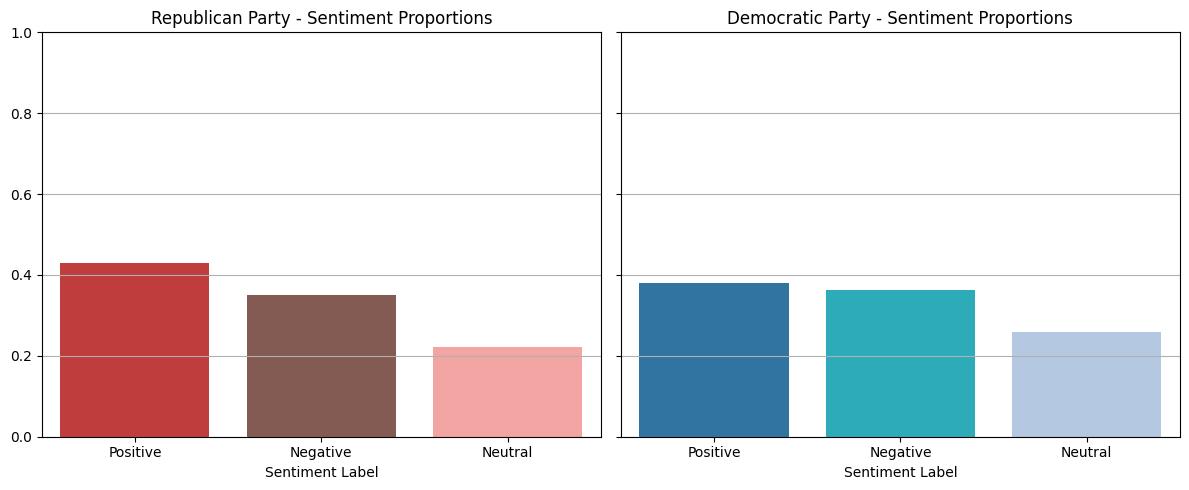

In [430]:
# Custom palettes
republican_palette = {'Positive': '#d62728', 'Neutral': '#ff9896', 'Negative': '#8c564b'}
democratic_palette = {'Positive': '#1f77b4', 'Neutral': '#aec7e8', 'Negative': '#17becf'}

# Function to compute normalized proportions
def get_normalized_df(df):
    proportions = df['sentiment_label'].value_counts(normalize=True)
    return pd.DataFrame({
        'sentiment_label': proportions.index,
        'proportion': proportions.values
    })

# Prepare normalized data
gop_norm = get_normalized_df(gop_df)
blue_norm = get_normalized_df(blue_df)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Republican plot
sns.barplot(data=gop_norm, x='sentiment_label', y='proportion',
            palette=republican_palette, ax=axes[0])
axes[0].set_title("Republican Party - Sentiment Proportions")
axes[0].set_xlabel("Sentiment Label")
axes[0].set_ylabel("")  # Remove y-axis label
axes[0].set_ylim(0, 1)
axes[0].grid(True, axis='y')

# Democratic plot
sns.barplot(data=blue_norm, x='sentiment_label', y='proportion',
            palette=democratic_palette, ax=axes[1])
axes[1].set_title("Democratic Party - Sentiment Proportions")
axes[1].set_xlabel("Sentiment Label")
axes[1].set_ylabel("")  # Remove y-axis label
axes[1].set_ylim(0, 1)
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.savefig('./visuals/sentiment_proportions.jpg')

plt.show()

In [215]:
# Get normalized proportions
gop_props = gop_df['sentiment_label'].value_counts(normalize=True)
blue_props = blue_df['sentiment_label'].value_counts(normalize=True)

# Combine into a single DataFrame
comparison_df = pd.DataFrame({
    'Republican': gop_props,
    'Democratic': blue_props
}).fillna(0)  # fill missing sentiments with 0 if one side lacks it

# Optional: sort for consistency
comparison_df = comparison_df.reindex(['Positive', 'Neutral', 'Negative'])

comparison_df

,Republican,Democratic
sentiment_label,,
Positive,0.428748,0.379332
Neutral,0.221809,0.258680
Negative,0.349442,0.361988


***Left Chart: Republican Party – Sentiment Proportions***

- **Positive (~43%):** The highest proportion of comments fall into the positive category, suggesting a relatively favorable tone among commenters.
- **Negative (~35%):** A significant portion still expresses negativity.
- **Neutral (~22%):** The smallest proportion; relatively fewer comments are neutral in tone.

**Colors:** Red shades are used to represent Republican sentiment:
- Deep red = positive
- Brown = negative
- Light red/pink = neutral

***Right Chart: Democratic Party – Sentiment Proportions***
- **Positive (~38%) and Negative (~36%):** These are nearly equal, indicating a more polarized or mixed sentiment among commenters.
- **Neutral (~26%):** Slightly higher than in the Republican chart.

**Colors:** Blue shades are used for Democratic sentiment:
- Dark blue = positive
- Teal = negative
- Light blue = neutral

**Interpretation**
- Republican comments skew more positive, with a clearer margin over negative and neutral.
- Democratic comments are more balanced between positive and negative, reflecting mixed or divided sentiment.
- Both parties have relatively low neutral sentiment, indicating that most commenters express clear opinions rather than ambivalence.

/var/folders/8l/y9q9c3j921xbnzrzd15zxy040000gn/T/ipykernel_8616/4238343236.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  gop_df['year_month'] = gop_df['timestamp'].dt.to_period('M').astype(str)
/var/folders/8l/y9q9c3j921xbnzrzd15zxy040000gn/T/ipykernel_8616/4238343236.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  blue_df['year_month'] = blue_df['timestamp'].dt.to_period('M').astype(str)


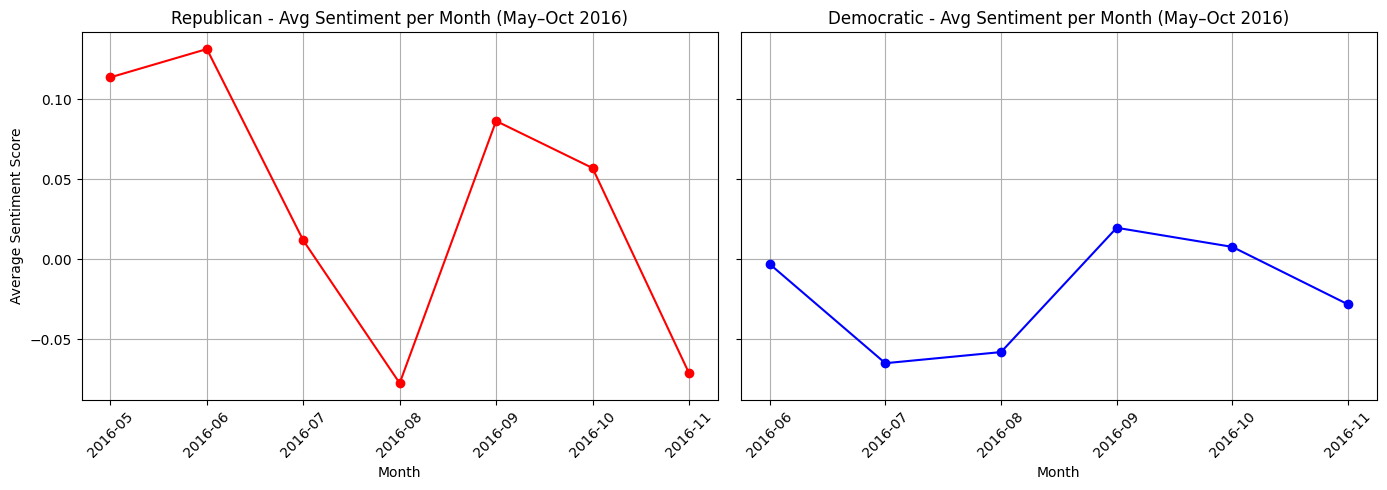

In [432]:
# Create year-month column
gop_df['year_month'] = gop_df['timestamp'].dt.to_period('M').astype(str)
blue_df['year_month'] = blue_df['timestamp'].dt.to_period('M').astype(str)

# Group by year-month and calculate mean sentiment
gop_monthly_avg = gop_df.groupby('year_month')['sentiment'].mean().sort_index()
blue_monthly_avg = blue_df.groupby('year_month')['sentiment'].mean().sort_index()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Republican plot (red)
axes[0].plot(gop_monthly_avg.index, gop_monthly_avg.values, marker='o', color='red')
axes[0].set_title('Republican - Avg Sentiment per Month (May–Oct 2016)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Sentiment Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Democratic plot (blue)
axes[1].plot(blue_monthly_avg.index, blue_monthly_avg.values, marker='o', color='blue')
axes[1].set_title('Democratic - Avg Sentiment per Month (May–Oct 2016)')
axes[1].set_xlabel('Month')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()

plt.savefig('./visuals/monthly_sentiment.jpg')
plt.show()

**Left Plot: Republican – Avg Sentiment per Month**
- **May & June:** High positive sentiment (above 0.10), peaking in June.
- **July–August:** Sentiment drops sharply, reaching a low in August (around -0.07), indicating a negative shift in public opinion.
- **September–October:** Sentiment rebounds to moderately positive levels.
- **November:** Drops again into negative territory just before or during the election.

**Interpretation:**
- Sentiment was volatile, with sharp up-and-down swings.
- Despite some high points, sentiment was negative twice, suggesting moments of public criticism or controversy around the Republican candidate.

**Right Plot: Democratic – Avg Sentiment per Month**
- **Overall Range:** Sentiment stayed below neutral (0) for most months.
- **July:** Reaches the lowest point (~ -0.07), possibly reflecting reactions to the DNC or controversies.
- **September:** Brief uptick into slightly positive territory, then a gradual decline again into negative by November.

**Interpretation:**
- Sentiment remained consistently low or negative, with no strong positive peak like the Republican trend had.
- The Democratic sentiment trend was less volatile but generally more negative on average.

**Overall Insight**
1. Republican sentiment was more volatile but showed periodic positivity.
2. Democratic sentiment was more stable but persistently negative.
3. These patterns may reflect public reactions to key campaign events, debates, or media coverage in the months leading to the 2016 U.S. Presidential Election.

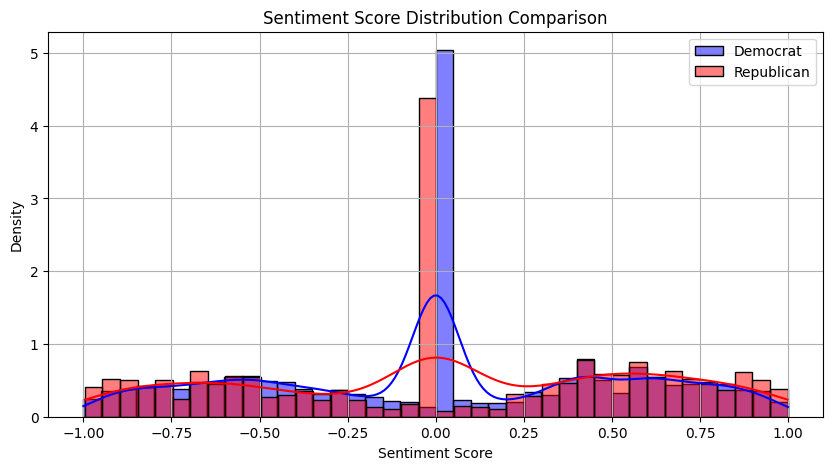

In [439]:
# Use histplot instead of kdeplot to avoid fill error and still visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(blue_df["sentiment"], label="Democrat", color='blue', kde=True, stat="density", bins=40, alpha=0.5)
sns.histplot(gop_df["sentiment"], label="Republican", color='red', kde=True, stat="density", bins=40, alpha=0.5)
plt.title("Sentiment Score Distribution Comparison")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.savefig('./visuals/sentiment_score_dist_comp.jpg')
plt.show()

This plot shows a sentiment score distribution comparison between Democratic (blue) and Republican (red) YouTube comments. The x-axis represents VADER sentiment scores, ranging from -1 (most negative) to +1 (most positive). The y-axis represents density, which shows how concentrated the values are at different sentiment levels.

It combines:
- Histogram bars (translucent red/blue): show the count/density of sentiment scores in each range (bin).
- KDE lines (smoothed curves): show the probability distribution of sentiment for each group.

***Key Observations***
- **Neutral Sentiment Spike:** Both distributions are sharply peaked around 0, indicating that most comments are neutral.
- Democrats (blue line) show a taller and narrower spike—meaning more tightly clustered near neutral.
- Republicans (red line) are slightly more spread out.

**Polarity Spread:**
- Republican comments have more density in both tails (negative and positive), suggesting a wider range of sentiment.
- Democratic comments are more concentrated around the center, with fewer strongly negative or strongly positive outliers.
- Positive Skew: The Republican curve appears to have a slightly higher density in the positive range, possibly reflecting more positive sentiment overall.

***Interpretation:***
- Democratic comments tend to be more neutral or cautious in tone, with fewer extreme sentiments.
- Republican comments exhibit a broader spectrum, including more strongly opinionated (positive and negative) remarks.
- This may indicate that discourse around Republican content is more polarizing, whereas Democratic content invites moderate or neutral responses.

### Alternative Model - HuggingFace

**Hugging Face Sentiment Analysis:**
Unlike VADER, which produces a numerical compound sentiment score ranging from -1 to 1, Hugging Face’s sentiment-analysis pipeline provides:
- A sentiment label: 'POSITIVE' or 'NEGATIVE'
- A confidence score: a probability between 0 and 1 indicating how confident the model is in its prediction

This approach offers classification-based sentiment analysis rather than a continuous sentiment spectrum.

Due to compatibility issues in JupyterLab, Hugging Face sentiment analysis was performed in Google Colab, which provided access to GPU acceleration—critical for processing large volumes of text efficiently.

Additionally, it was necessary to enable text truncation, as Hugging Face models (particularly RoBERTa-based ones) impose a token limit and would not process longer comments without truncation enabled.

In [280]:
hf_gop = pd.read_csv('./rep_df_HF.csv')
hf_gop = hf_gop.drop(columns=['Unnamed: 0'])

In [282]:
hf_gop.head()

,Comment,timestamp,sentiment,sentiment_label,year_month,HF_Sentiment,HF_Score_Confidence
0,I totally support and endorse Donald.,2016-06-25 10:54:46+00:00,0.6764,Positive,2016-06,POSITIVE,0.998792
1,Is that Tito Ortiz from the UFC next to the la...,2016-06-07 21:11:38+00:00,0.5984,Positive,2016-06,POSITIVE,0.988146
2,"I actually can't watch this, first 20 minutes ...",2016-05-31 14:22:36+00:00,0.7506,Positive,2016-05,NEGATIVE,0.999508
3,he is a coward,2016-05-31 08:16:06+00:00,-0.4588,Negative,2016-05,NEGATIVE,0.999319
4,😴😴😴,2016-05-31 05:53:00+00:00,0.0000,Neutral,2016-05,POSITIVE,0.997923


In [286]:
hf_dem = pd.read_csv('./dem_df_HF.csv')
hf_dem = hf_dem.drop(columns=['Unnamed: 0'])

In [288]:
hf_dem.head()

,Comment,timestamp,sentiment,sentiment_label,year_month,HF_Sentiment,HF_Label_Confidence
0,www.infowars.com,2016-10-25 21:47:05+00:00,0.0000,Neutral,2016-10,NEGATIVE,0.988892
1,She's so full of shit.,2016-10-20 03:25:18+00:00,-0.5945,Negative,2016-10,NEGATIVE,0.999483
2,Empty promises and emotional rhetoric to persu...,2016-10-19 11:48:47+00:00,0.9325,Positive,2016-10,NEGATIVE,0.997069
3,"Black live matter Hillary say so, then what ab...",2016-10-19 03:20:58+00:00,0.2845,Positive,2016-10,NEGATIVE,0.996861
4,She cheated Bernie out of nomination.,2016-10-19 01:25:36+00:00,-0.5106,Negative,2016-10,NEGATIVE,0.999420


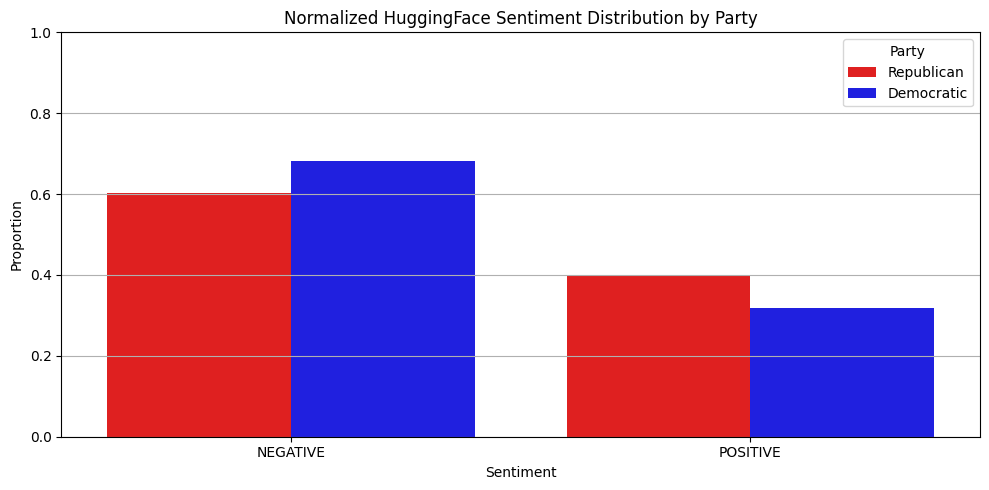

In [387]:
hf_gop_norm = hf_gop['HF_Sentiment'].value_counts(normalize=True).rename_axis('Sentiment').reset_index(name='Proportion')
hf_gop_norm['Party'] = 'Republican'

hf_dem_norm = hf_dem['HF_Sentiment'].value_counts(normalize=True).rename_axis('Sentiment').reset_index(name='Proportion')
hf_dem_norm['Party'] = 'Democratic'

# Step 2: Combine both into a single DataFrame
hf_combined = pd.concat([hf_gop_norm, hf_dem_norm])

# Step 3: Plot normalized bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=hf_combined, x='Sentiment', y='Proportion', hue='Party',
            palette={'Republican': 'red', 'Democratic': 'blue'})

plt.title('Normalized HuggingFace Sentiment Distribution by Party')
plt.ylabel('Proportion')
plt.xlabel('Sentiment')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Party')
plt.tight_layout()
plt.savefig('./visuals/HuggingFace_Sentiment_Dist.jpg')

plt.show()

### 2020 Election

In [342]:
# Updated Function for 2020 elections

def data_processor2020(df1, df2):
    # Concatenating dataframes and only keeping 1 top-level comment per user (no replies)
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.drop_duplicates(subset=['Comment'])
    df = df.drop_duplicates(subset=['Username'])

    # Dropping nulls
    df = df.dropna()

    # Changing timestamp object type to Datetime
    df['timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Filter for May 1 - Nov 4, 2016
    mask = (df['timestamp'] >= '2020-05-01') & (df['timestamp'] <= '2020-11-02')
    df = df.loc[mask].copy()

    # Applying SentimentIntensityAnalyzer
    df['sentiment'] = df['Comment'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral')

    df = df.drop(columns = ['Username', 'VideoID', 'Date', 'Timestamp'], axis=1)

    return df

***Donald Trump & the Republican Party***

In [305]:
trump2020 = pd.read_csv('./2020_data/2020trump_comments.csv')
rep2020 = pd.read_csv('./2020_data/2020Rep_debate_comments.csv')

In [307]:
trump2020.isnull().sum()

Timestamp     0
Username     26
VideoID       0
Comment       1
Date          0
dtype: int64

In [309]:
rep2020.isnull().sum()

Timestamp     0
Username     11
VideoID       0
Comment       0
Date          0
dtype: int64

In [311]:
trump2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10398 entries, 0 to 10397
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  10398 non-null  object
 1   Username   10372 non-null  object
 2   VideoID    10398 non-null  object
 3   Comment    10397 non-null  object
 4   Date       10398 non-null  object
dtypes: object(5)
memory usage: 406.3+ KB


In [313]:
rep2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17235 entries, 0 to 17234
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  17235 non-null  object
 1   Username   17224 non-null  object
 2   VideoID    17235 non-null  object
 3   Comment    17235 non-null  object
 4   Date       17235 non-null  object
dtypes: object(5)
memory usage: 673.4+ KB


In [344]:
gop2020 = data_processor2020(trump2020, rep2020)

In [346]:
gop2020.shape

(21251, 4)

In [348]:
gop_df.head()

,Comment,timestamp,sentiment,sentiment_label,year_month
464,I totally support and endorse Donald.,2016-06-25 10:54:46+00:00,0.6764,Positive,2016-06
465,Is that Tito Ortiz from the UFC next to the la...,2016-06-07 21:11:38+00:00,0.5984,Positive,2016-06
466,"I actually can't watch this, first 20 minutes ...",2016-05-31 14:22:36+00:00,0.7506,Positive,2016-05
467,he is a coward,2016-05-31 08:16:06+00:00,-0.4588,Negative,2016-05
468,😴😴😴,2016-05-31 05:53:00+00:00,0.0000,Neutral,2016-05


In [350]:
gop_df['sentiment'].mean()

0.039240768277571246

***Hillary Clinton & the Democratic Party***

In [369]:
biden2020 = pd.read_csv('./2020_data/2020biden_comments.csv')
dem2020 = pd.read_csv('./2020_data/2020Dem_debate_comments.csv')

In [359]:
biden2020.isnull().sum()

Timestamp    0
Username     9
VideoID      0
Comment      0
Date         0
dtype: int64

In [361]:
dem2020.isnull().sum()

Timestamp     0
Username     40
VideoID       0
Comment       0
Date          0
dtype: int64

In [363]:
biden2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357 entries, 0 to 4356
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  4357 non-null   object
 1   Username   4348 non-null   object
 2   VideoID    4357 non-null   object
 3   Comment    4357 non-null   object
 4   Date       4357 non-null   object
dtypes: object(5)
memory usage: 170.3+ KB


In [365]:
dem2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25944 entries, 0 to 25943
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  25944 non-null  object
 1   Username   25904 non-null  object
 2   VideoID    25944 non-null  object
 3   Comment    25944 non-null  object
 4   Date       25944 non-null  object
dtypes: object(5)
memory usage: 1013.6+ KB


In [371]:
blue2020 = data_processor2020(biden2020, dem2020)

In [373]:
blue2020.shape

(20629, 4)

In [375]:
blue2020.head()

,Comment,timestamp,sentiment,sentiment_label
0,Pathetic 🤣🤣🤣🤣🤣,2020-10-22 11:51:07+00:00,0.9062,Positive
1,DONALD TRUMPED BIDEN 2020 November.!!!!,2020-10-21 09:56:46+00:00,0.0000,Neutral
2,this is a biden rally ? ..... laughable :...,2020-10-09 01:48:54+00:00,0.0516,Positive
3,"LOlOL Democrats logic "" Joe will be great rest...",2020-09-27 06:52:40+00:00,0.7058,Positive
4,“Joe is a Problem solver” LOL Best oxymoron,2020-09-26 03:26:27+00:00,0.6739,Positive


In [377]:
blue2020['sentiment'].mean()

0.02299896262543022

### 2024 Election

In [389]:
# Updated Function for 2024 elections

def data_processor2024(df1, df2):
    # Concatenating dataframes and only keeping 1 top-level comment per user (no replies)
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.drop_duplicates(subset=['Comment'])
    df = df.drop_duplicates(subset=['Username'])

    # Dropping nulls
    df = df.dropna()

    # Changing timestamp object type to Datetime
    df['timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Filter for May 1 - Nov 4, 2016
    mask = (df['timestamp'] >= '2024-05-01') & (df['timestamp'] <= '2024-11-04')
    df = df.loc[mask].copy()

    # Applying SentimentIntensityAnalyzer
    df['sentiment'] = df['Comment'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral')

    df = df.drop(columns = ['Username', 'VideoID', 'Date', 'Timestamp'], axis=1)

    return df

***Donald Trump & the Republican Party***

In [394]:
trump2024 = pd.read_csv('./2024_data/2024trump_comments.csv')
rep2024 = pd.read_csv('./2024_data/2024Rep_debate_comments.csv')

In [400]:
gop2024 = data_processor2024(trump2024, rep2024)

In [402]:
gop2024.shape

(42457, 4)

In [404]:
gop2024.head()

,Comment,timestamp,sentiment,sentiment_label
0,I LOVE TRUMP,2024-10-19 23:31:02+00:00,0.6369,Positive
1,Walter Tunnel,2024-10-09 22:33:59+00:00,0.0000,Neutral
2,2:30 if you dont feel it like this guy i feel ...,2024-10-08 03:22:21+00:00,-0.6818,Negative
3,"You’re so wonderful, Sir!",2024-09-24 05:28:03+00:00,0.6468,Positive
4,BEST PRESIDENT EVER PRESIDENT TRUMP2024🇺🇸❤️🦅,2024-09-24 03:43:35+00:00,0.7125,Positive


In [406]:
gop2024['sentiment'].mean()

0.10459350166050357

***Hillary Clinton & the Democratic Party***

In [420]:
kamala2024 = pd.read_csv('./2024_data/2024kamala_comments.csv')
rep2024 = pd.read_csv('./2024_data/2024Dem_debate_comments.csv')

In [422]:
gop2024 = data_processor2024(trump2024, rep2024)

In [424]:
gop2024.shape

(33344, 4)

In [426]:
gop2024.head()

,Comment,timestamp,sentiment,sentiment_label
0,I LOVE TRUMP,2024-10-19 23:31:02+00:00,0.6369,Positive
1,Walter Tunnel,2024-10-09 22:33:59+00:00,0.0000,Neutral
2,2:30 if you dont feel it like this guy i feel ...,2024-10-08 03:22:21+00:00,-0.6818,Negative
3,"You’re so wonderful, Sir!",2024-09-24 05:28:03+00:00,0.6468,Positive
4,BEST PRESIDENT EVER PRESIDENT TRUMP2024🇺🇸❤️🦅,2024-09-24 03:43:35+00:00,0.7125,Positive


In [428]:
gop2024['sentiment'].mean()

0.06574532149712091

### Observations

**2016:** While the mean sentiment for both the Republican and Democratic parties was generally neutral, a closer examination revealed slightly more positive and less negative sentiment toward the Republican Party.

**2020:** Sentiment toward both parties was relatively balanced, with no significant difference in mean sentiment scores.

**2024:** In 2024, the mean sentiment was markedly more positive for the Republican Party—approximately 66%—compared to the Democratic Party. This aligns well with the actual election outcome, in which Donald Trump and the GOP secured a decisive victory.